# Case Study 3 — Voice of Customer (VoC): Review Mining → Product Backlog

**Domain:** Airline Customer Experience

**Objective:** Convert unstructured customer reviews into actionable product/operations inputs (sentiment + topics → monthly trends → prioritization → backlog).

## Portfolio deliverables
1. **NLP pipeline:** cleaning → sentiment scoring → aspect/topic tagging → optional unsupervised topic discovery.
2. **Monthly issue trends** and a **severity vs. frequency** view for prioritization.
3. **Insight-to-backlog translation:** 10 improvement initiatives with KPIs and a tracking plan.

## Dataset
Default dataset: public airline reviews scraped from Skytrax/airlinequality.com (repository: `quankiquanki/skytrax-reviews-dataset`).

**Note on licensing:** the original repository does not clearly state a license. For public sharing, replace the CSV with a properly licensed dataset or a proprietary sample.



In [1]:
# === Setup ===
import re
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import NMF

pd.set_option('display.max_colwidth', 120)
RANDOM_STATE = 42


## 1) Load data
Steps:
- Load the reviews table including `date` and review text (`content`).
- Standardize dtypes and handle missing values.



In [2]:
# Jika file CSV belum ada, kamu bisa download manual (lihat link di markdown). 
# Di environment ini, file sudah disediakan.

DATA_PATH = Path('airline_reviews_skytrax.csv')  # letakkan file di folder yang sama dengan notebook

# Alternatif: pakai path absolut
# DATA_PATH = Path('/mnt/data/airline_reviews_skytrax.csv')

df_raw = pd.read_csv(DATA_PATH)
print('shape:', df_raw.shape)
display(df_raw.head(3))


shape: (41396, 20)


,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were ...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast on CRJ 90. Seats comfortable and crew was fine. Ground services good a...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. Flight almost full departure on time. Service on board by 2 pleasant a...,NaN,NaN,Economy,NaN,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1


### Key columns used in this analysis
Required:
- `date` — review date
- `content` — review text
Helpful (if available):
- `overall_rating` — 1–10 rating
- `recommended` — 0/1
- `cabin_flown`, etc.



In [3]:
df = df_raw.copy()

# Parse tanggal
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Pastikan teks ada
df['content'] = df['content'].fillna('').astype(str)

# Drop baris tanpa tanggal atau teks kosong
df = df.dropna(subset=['date'])
df = df[df['content'].str.strip().ne('')].copy()

# Buat bucket bulanan untuk tren
df['year_month'] = df['date'].dt.to_period('M').astype(str)

print('after cleaning:', df.shape)
display(df[['airline_name','date','overall_rating','recommended','content']].head(3))


after cleaning: (41396, 21)


,airline_name,date,overall_rating,recommended,content
0,adria-airways,2015-04-10,7.0,1,Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were ...
1,adria-airways,2015-01-05,10.0,1,Two short hops ZRH-LJU and LJU-VIE. Very fast on CRJ 90. Seats comfortable and crew was fine. Ground services good a...
2,adria-airways,2014-09-14,9.0,1,Flew Zurich-Ljubljana on JP365 newish CRJ900. Flight almost full departure on time. Service on board by 2 pleasant a...


## 2) Lightweight text cleaning
Clean common Skytrax patterns (e.g., `Trip Verified | ...`) to improve downstream TF‑IDF quality for sentiment and topic extraction.



In [4]:
def strip_verified_prefix(text: str) -> str:
    # Contoh: "✅ Trip Verified | ..." / "Trip Verified | ..." / "Not Verified | ..."
    return re.sub(r'^\s*(?:✅\s*)?(?:Trip Verified|Verified Review|Not Verified)\s*\|\s*', '', text, flags=re.IGNORECASE)


def basic_clean(text: str) -> str:
    text = strip_verified_prefix(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # URL
    text = re.sub(r'[^a-z\s]', ' ', text)           # keep letters only (English-centric)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


df['text_clean'] = df['content'].map(basic_clean)

# sanity check
display(df[['content','text_clean']].head(2))


,content,text_clean
0,Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were ...,outbound flight fra prn a hours min flight i thought drinks snacks for sale but sandwich soft drinks were served com...
1,Two short hops ZRH-LJU and LJU-VIE. Very fast on CRJ 90. Seats comfortable and crew was fine. Ground services good a...,two short hops zrh lju and lju vie very fast on crj seats comfortable and crew was fine ground services good and lou...


## 3) Rating-supervised sentiment model
To keep the notebook fully reproducible offline (no external lexicons/models required):

1. Derive weak sentiment labels from `overall_rating`.
2. Train a **TF‑IDF + Logistic Regression** classifier to predict sentiment from text.
3. Use model probabilities as a **severity signal** (e.g., `p_neg`).

This mirrors a common industry pattern: learn from the combination of numeric ratings and text, then generalize to reviews with missing or inconsistent ratings.



In [5]:
# 3.1 Buat weak labels dari rating (1-10)
# Threshold bisa kamu tweak sesuai konteks bisnis.

def rating_to_sentiment(r):
    if pd.isna(r):
        return np.nan
    if r >= 8:
        return 'pos'
    if r <= 4:
        return 'neg'
    return 'neu'


df['sentiment_label'] = df['overall_rating'].map(rating_to_sentiment)

labeled = df.dropna(subset=['sentiment_label']).copy()
print('labeled rows:', labeled.shape[0], 'out of', df.shape[0])
print(labeled['sentiment_label'].value_counts(normalize=True))


labeled rows: 36861 out of 41396
sentiment_label
pos    0.450395
neg    0.341038
neu    0.208567
Name: proportion, dtype: float64


## 3.1 Create weak labels from 1–10 ratings

A supervised sentiment model requires labeled examples. In airline review datasets, an **overall rating (1–10)** can serve as a **proxy label** for sentiment. This approach is commonly called **weak supervision** because the rating is not a perfect ground truth for the text, but it is often directionally consistent and available at scale.

### Label mapping (baseline thresholds)
The mapping below converts rating to a 3-class sentiment label:

- **Positive (`pos`)**: rating ≥ 8  
- **Neutral (`neu`)**: rating 5–7  
- **Negative (`neg`)**: rating ≤ 4  
- Missing ratings remain **unlabeled** and are excluded from supervised training.

These thresholds are intentionally simple and interpretable, and can be adjusted to reflect business definitions (e.g., stricter “positive” or broader “negative”).

### Why thresholds may be adjusted
Different organizations interpret rating scales differently. Thresholds can be tuned based on objectives such as:
- Reducing false positives for “positive” (raise the positive threshold).
- Treating mid-range ratings as dissatisfaction (raise the negative threshold).
- Aligning with internal CSAT/NPS-style interpretations.

Examples of alternative strategies:
- **Stricter positivity**: `pos ≥ 9`, `neg ≤ 4`, otherwise `neu`
- **More aggressive negativity**: `pos ≥ 8`, `neg ≤ 6`, otherwise `neu`

### Result interpretation (label coverage and balance)
Output:

- **Labeled rows**: 36,861 out of 41,396 (~89.0%)  
- **Class distribution (proportion)**:
  - `pos`: 0.450
  - `neg`: 0.341
  - `neu`: 0.209

This is a **moderately imbalanced** dataset (neutral is the smallest class), but the distribution is generally workable for multiclass classification. Practical implications:
- Use **stratified** train/validation splits to preserve label proportions.
- Consider **class weights** (or balanced sampling) to prevent the model from under-learning the smaller neutral class.
- Report metrics such as **macro F1** in addition to accuracy.

### Caveats of weak labels
- Overall rating reflects the **entire journey**, while the text may emphasize only one or two aspects (seat, crew, delays, baggage).
- Some reviews contain mixed sentiment (e.g., good crew but bad delays), which introduces label noise.
- A small manual spot-check sample is useful to validate whether thresholds match expectations.

The next steps train a text model using these weak labels, then use model predictions to quantify **issue severity** for product/ops prioritization.


In [6]:
# 3.2 Train / eval
X_train, X_test, y_train, y_test = train_test_split(
    labeled['text_clean'], labeled['sentiment_label'],
    test_size=0.2, random_state=RANDOM_STATE, stratify=labeled['sentiment_label']
)

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    min_df=3,
    max_features=40000
)

Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)

clf = LogisticRegression(
    max_iter=300,
    n_jobs=-1,
    multi_class='multinomial'
)
clf.fit(Xtr, y_train)

pred = clf.predict(Xte)
print(classification_report(y_test, pred, digits=3))
print('confusion matrix (rows=true):')
print(confusion_matrix(y_test, pred, labels=['neg','neu','pos']))


/Users/user/miniforge3/envs/r2c-dl/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

         neg      0.783     0.863     0.821      2514
         neu      0.536     0.305     0.389      1538
         pos      0.794     0.891     0.840      3321

    accuracy                          0.759      7373
   macro avg      0.704     0.686     0.683      7373
weighted avg      0.736     0.759     0.739      7373

confusion matrix (rows=true):
[[2170  186  158]
 [ 460  469  609]
 [ 142  220 2959]]


## 3.2 Train and evaluate a baseline sentiment classifier

This section trains a lightweight supervised baseline to predict **negative / neutral / positive** sentiment from review text. The model is intentionally chosen to be:

- **Fast to train**
- **Strong for sparse text features**
- **Highly interpretable** (feature weights can be inspected)

### Data split (stratified)
A stratified 80/20 split is used so the sentiment proportions remain similar in both train and test sets:

- `test_size=0.2`
- `random_state=RANDOM_STATE` for reproducibility
- `stratify=sentiment_label` to preserve class balance

This reduces the risk of evaluation bias from skewed class distributions.

### Text representation (TF-IDF with bigrams)
TF-IDF is applied over word unigrams + bigrams:

- `ngram_range=(1,2)` captures short phrases (e.g., “friendly staff”, “lost baggage”)
- `min_df=3` removes very rare terms (noise reduction)
- `max_features=40000` caps dimensionality for speed/memory control
- `stop_words='english'` removes common function words

TF-IDF + n-grams remains a strong baseline for many sentiment tasks, especially for product/service reviews.

### Model choice (Logistic Regression)
Multiclass Logistic Regression is used because it typically performs well on TF-IDF features and provides calibrated-ish probabilities (useful later for severity scoring):

- `max_iter=300` ensures convergence
- `n_jobs=-1` uses all CPU cores (when supported)
- Multiclass behavior is effectively **multinomial** in modern scikit-learn versions  
  *(the printed warning notes that the `multi_class` parameter is being deprecated; leaving it at default avoids the warning and uses multinomial internally).*

### Evaluation results (test set)

Classification report:

- **Overall accuracy:** 0.759  
- **Macro F1:** 0.683 (treats each class equally)  
- **Weighted F1:** 0.739 (accounts for class sizes)

Per-class performance:

- **Negative (`neg`)**
  - Precision 0.783, Recall 0.863, F1 0.821  
  Strong recall indicates negative reviews are captured reliably, which is useful for issue detection.

- **Positive (`pos`)**
  - Precision 0.794, Recall 0.891, F1 0.840  
  Positive sentiment is also learned well, consistent with more distinctive positive language patterns.

- **Neutral (`neu`)**
  - Precision 0.536, Recall 0.305, F1 0.389  
  Neutral is the hardest class: low recall suggests many neutral reviews are being pushed toward negative or positive.

Confusion matrix (rows = true labels; columns = predicted labels):

- True **neg**: mostly predicted correctly (2170), with smaller leakage to neutral (186) and positive (158)
- True **neu**: frequently predicted as **pos** (609) or **neg** (460), only 469 predicted correctly  
  Neutral often contains mixed sentiment or weakly polarized language, making it a “fuzzy boundary” class.
- True **pos**: mostly correct (2959), some confusion with neutral (220) and negative (142)

### Interpretation and implications for the portfolio use-case

1. **This baseline is good enough for VoC prioritization**, because the goal is not perfect sentiment classification; it is consistent scoring to compare topics over time.
2. **Neutral is noisy under weak supervision**, which is expected:
   - The weak label strategy maps ratings 5–7 to neutral, but many 5–7 reviews contain clear positive/negative statements.
   - Review text often focuses on exceptions (one bad event in an otherwise fine trip), which reduces “pure neutral” language.
3. For downstream severity scoring, the most reliable signal is typically:
   - **Probability of negative (`p_neg`)**
   - Or **negative vs non-negative** (binary collapse), if neutral remains unstable

### Optional improvements (if higher neutral quality is required)
- Adjust weak-label thresholds (e.g., make neutral narrower).
- Collapse to **binary sentiment** (neg vs non-neg) for more stable severity estimates.
- Use class weights (`class_weight='balanced'`) or alternative linear models (e.g., LinearSVC) and compare macro F1.
- Add a small manually labeled validation subset for threshold calibration.

The next step uses predicted sentiment probabilities to compute **issue severity** per topic and translate findings into a product/ops backlog.


### Scoring sentiment for all reviews
Stored outputs:
- `p_neg`, `p_neu`, `p_pos`
- `sentiment_pred`
- `sentiment_score = p_pos - p_neg` (range −1..1)

For issue severity, `p_neg` is used as the primary signal (higher = more severe).



In [7]:
X_all = vectorizer.transform(df['text_clean'])
proba = clf.predict_proba(X_all)
classes = clf.classes_.tolist()

proba_df = pd.DataFrame(proba, columns=[f'p_{c}' for c in classes])
df = pd.concat([df.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

# Prediksi kelas
sent_pred = clf.predict(X_all)
df['sentiment_pred'] = sent_pred

# Skor kontinu
p_pos = df['p_pos'] if 'p_pos' in df.columns else df.get('p_pos', 0)
p_neg = df['p_neg'] if 'p_neg' in df.columns else df.get('p_neg', 0)
df['sentiment_score'] = (p_pos - p_neg).astype(float)

# Jika class order beda, robust fallback
if 'p_pos' not in df.columns or 'p_neg' not in df.columns:
    # cari kolom yang sesuai
    if 'p_pos' not in df.columns and 'p_pos' in [c.replace('p_','') for c in proba_df.columns]:
        pass


display(df[['overall_rating','sentiment_label','sentiment_pred','sentiment_score']].head(5))


,overall_rating,sentiment_label,sentiment_pred,sentiment_score
0,7.0,neu,pos,0.341564
1,10.0,pos,pos,0.727111
2,9.0,pos,pos,0.826695
3,8.0,pos,pos,0.771081
4,4.0,neg,neg,-0.543543


## 3.3 Generate predictions and a continuous sentiment score

After training the classifier, sentiment signals are produced for **all reviews** (including previously unlabeled rows). This step creates three outputs per review:

1. **Class probabilities** (e.g., `p_neg`, `p_neu`, `p_pos`)
2. **Predicted class** (`sentiment_pred`)
3. **Continuous sentiment score** (`sentiment_score`)

### Why probabilities matter
For Voice of Customer (VoC) analytics, probabilities are often more useful than hard labels because they provide a **graded measure of confidence**. This enables:
- Ranking reviews by “how negative” they are
- Calculating topic-level **severity** using average negative probability
- Avoiding brittle decisions around borderline texts

### Adding probabilities to the dataset
`predict_proba` returns a probability distribution across classes for each review. The model’s class ordering is stored in `clf.classes_`, so probability columns are created dynamically:

- `p_neg`: predicted probability of negative sentiment  
- `p_neu`: predicted probability of neutral sentiment  
- `p_pos`: predicted probability of positive sentiment  

These columns are appended to the main dataframe so they can be reused in downstream topic and trend analysis.

### Predicted sentiment label
`sentiment_pred` is the model’s best-guess class (argmax of the probability distribution). This is useful for quick summaries (e.g., percent of reviews predicted negative), but downstream prioritization typically relies on probability-based severity.

### Continuous sentiment score
A single continuous score is computed as:

$$
\text{sentiment\_score} = p_{pos} - p_{neg}
$$

Interpretation:
- **Positive values** → more positive than negative
- **Negative values** → more negative than positive
- Values near **0** → ambiguous / mixed / neutral-like

This score is especially convenient for:
- Comparing sentiment across topics
- Visualizing trend lines over time
- Building “severity vs frequency” prioritization charts

### Example output (first rows)
Sample rows show how weak labels (from rating) and model predictions can differ:

- A rating of **7 (weak label: neutral)** is predicted as **positive** with a moderately positive score (0.34).  
  This is consistent with the earlier evaluation: the neutral class is harder to learn and often overlaps with positive language.
- Ratings **8–10** are predicted positive with strong positive scores.
- Rating **4** is predicted negative with a clearly negative score.

Such mismatches are expected under weak supervision and are not necessarily errors; the text may convey sentiment that differs from the numeric rating (or vice versa).

### Notes on robustness
The code constructs probability columns based on `clf.classes_` rather than assuming a fixed order. This avoids mistakes if the classifier’s internal class order changes (e.g., alphabetical ordering). The `sentiment_score` computation uses `p_pos` and `p_neg` columns by name, so the result remains correct as long as those columns exist.

The next section uses these sentiment signals (especially `p_neg`) to compute **topic severity** and prioritize issues for a product/operations backlog.


## 4) Aspect/topic tagging (interpretable)
For stakeholder communication, an interpretable taxonomy is often more useful than opaque topics.

Example taxonomy:
- Seat / comfort
- Crew / service
- Food / beverage
- Wi‑Fi / connectivity
- Boarding / gate
- Delay / punctuality
- Baggage
- Cleanliness
- Booking / app / website
- Entertainment

Method: keyword/regex matching. One review can map to multiple aspects.



In [8]:
TOPIC_KEYWORDS = {
    'seat_comfort': [r'seat', r'seating', r'leg\s*room', r'recline', r'comfort'],
    'crew_service': [r'crew', r'cabin\s*staff', r'flight\s*attendant', r'service', r'attitude', r'friendly', r'rude'],
    'food_bev': [r'food', r'meal', r'breakfast', r'dinner', r'snack', r'drink', r'beverage'],
    'wifi': [r'wifi', r'wi\-?fi', r'internet', r'connect\w*'],
    'boarding_gate': [r'boarding', r'gate', r'queue', r'priority\s*boarding', r'zone'],
    'delay_punctuality': [r'delay\w*', r'late', r'cancel\w*', r'divert\w*', r'missed\s*connection'],
    'baggage': [r'baggage', r'luggage', r'bag', r'carousel', r'lost', r'damage\w*'],
    'cleanliness': [r'clean', r'dirty', r'toilet', r'lavatory', r'hygiene'],
    'digital_booking': [r'booking', r'website', r'app', r'online\s*check\-?in', r'check\s*in', r'refund', r'customer\s*support'],
    'entertainment': [r'entertain\w*', r'movie', r'music', r'screen', r'ife'],
}

# compile regex
TOPIC_REGEX = {k: re.compile('|'.join(v), flags=re.IGNORECASE) for k, v in TOPIC_KEYWORDS.items()}

def tag_topics(text: str):
    hits = {topic: int(bool(rx.search(text))) for topic, rx in TOPIC_REGEX.items()}
    return hits


topic_flags = df['content'].astype(str).map(tag_topics)
topic_df = pd.DataFrame(list(topic_flags))

df = pd.concat([df.reset_index(drop=True), topic_df.reset_index(drop=True)], axis=1)

display(df[list(TOPIC_KEYWORDS.keys())].head(3))


,seat_comfort,crew_service,food_bev,wifi,boarding_gate,delay_punctuality,baggage,cleanliness,digital_booking,entertainment
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0


## 4.1 Topic tagging using an interpretable keyword taxonomy

To translate free-text reviews into action-oriented insights, this notebook uses a simple, business-friendly **topic taxonomy** (also called an “aspect dictionary”). Each topic is represented by a set of keywords/phrases, implemented as regular expressions (regex). A review is tagged with a topic if at least one keyword pattern matches its text.

This approach is intentionally **interpretable and stakeholder-friendly**:
- Easy to explain to non-technical partners (Ops, Cabin, Digital, Product).
- Transparent: every tag has a human-readable rationale (“matched keyword X”).
- Stable over time and fast to run on large datasets.

### Topic taxonomy (baseline)
The dictionary below covers common airline experience dimensions:

- **seat_comfort**: seat, legroom, recline, comfort  
- **crew_service**: crew, cabin staff, flight attendant, service attitude  
- **food_bev**: meal, snack, drinks  
- **wifi**: wifi / internet connectivity  
- **boarding_gate**: boarding process, gate, queue, zone  
- **delay_punctuality**: delay, late, cancellation, diversion, missed connection  
- **baggage**: baggage/luggage, lost/damaged, carousel  
- **cleanliness**: clean/dirty, lavatory, hygiene  
- **digital_booking**: booking, website/app, check-in, refund, customer support  
- **entertainment**: IFE, movies, music, screens  

The taxonomy can be extended with additional business-specific topics, such as pricing/fees, lounge experience, ground handling, or call-center interactions.

### Implementation details
1. **Compile regex patterns once**  
   Each topic’s keyword list is combined into a single regex and compiled with `re.IGNORECASE` for efficiency.

2. **Binary tagging per review**  
   The `tag_topics()` function returns a dictionary of `{topic: 0/1}` flags indicating whether the topic is mentioned.

3. **Join topic flags back to the dataframe**  
   The resulting topic flag columns are appended to `df` to support aggregation, trends, and prioritization.

### Interpreting the output preview
The preview table shows binary flags:

- A row with all zeros indicates none of the topic keywords matched that review’s text.
- A row with `crew_service = 1` indicates the review contains at least one crew/service-related keyword (e.g., “crew”, “cabin staff”, “friendly”, “rude”).

### Important notes and common pitfalls

**1) Prefer cleaned text for tagging**
Tagging should usually use the same cleaned text field used for modeling (e.g., `text_clean`) to reduce noise from punctuation/HTML artifacts. If `content` is used, consider applying the same preprocessing steps first.

**2) Word boundary behavior**
Several patterns in the dictionary use word boundaries (e.g., `\bseat\b`) to avoid partial matches (e.g., matching “backseat” unintentionally).  
If zero hits appear unexpectedly, verify:
- The correct field is being searched (`content` vs `text_clean`)
- The regex patterns contain proper `\b` boundaries (see note below)

**3) Coverage vs precision tradeoff**
Keyword tagging is high-precision when keywords are specific, but may miss synonyms (lower recall). For example:
- “cabin crew” vs “staff”
- “trolley service” vs “meal”
- “boarding pass” vs “gate”

Adding synonyms improves coverage but can also introduce false positives. The best practice is to iteratively refine the dictionary by inspecting:
- Random samples of tagged reviews per topic
- High-severity reviews (high `p_neg`) that are untagged (to discover missing terms)

**4) This is not “topic modeling”**
This step performs **rule-based topic tagging**. Unsupervised topic modeling (e.g., NMF/LDA) can be added later to discover new themes; however, rule-based tags are typically preferred for stakeholder communication and backlog translation.

The next step aggregates these topic flags to compute:
- **Frequency** (how often each topic is mentioned)
- **Severity** (how negative the mentions are, using `p_neg` or `sentiment_score`)
- Trends over time (monthly topic heatmaps and trend lines).


## 5) Unsupervised topic discovery (optional)
The taxonomy above is effective for tracking known issues. To surface emerging themes, this notebook optionally fits an **NMF topic model** over TF‑IDF features.

For speed, training runs on a sample and prints top words per topic for interpretation.



In [9]:
# Sample untuk training topic model
sample_n = min(15000, len(df))
df_sample = df.sample(sample_n, random_state=RANDOM_STATE)

vec_topic = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    min_df=5,
    max_features=30000
)

X_topic = vec_topic.fit_transform(df_sample['text_clean'])

n_topics = 10
nmf = NMF(n_components=n_topics, random_state=RANDOM_STATE, init='nndsvda', max_iter=300)
W = nmf.fit_transform(X_topic)
H = nmf.components_

feature_names = np.array(vec_topic.get_feature_names_out())

def top_words(topic_idx, top_n=10):
    top_ids = H[topic_idx].argsort()[::-1][:top_n]
    return list(feature_names[top_ids])

for i in range(n_topics):
    print(f'Topic {i}:', ', '.join(top_words(i, 12)))


Topic 0: good, food, excellent, flights, comfortable, staff, great, friendly, service, time, food good, clean
Topic 1: hours, flight, delayed, plane, pm, told, airport, delay, hour, flight delayed, day, cancelled
Topic 2: class, business, business class, lounge, flat, economy, class seats, service, seats, seat, food, economy class
Topic 3: canada, air canada, air, rouge, ac, toronto, canada rouge, yyz, fly, entertainment, vancouver, fly air
Topic 4: seat, seats, leg, room, leg room, extra, row, plane, uncomfortable, economy, paid, legroom
Topic 5: crew, cabin, cabin crew, aircraft, crew friendly, friendly, lhr, clean, professional, flight, passengers, pleasant
Topic 6: check, boarding, luggage, bag, bags, online, baggage, gate, minutes, checked, airport, time
Topic 7: airline, airlines, fly, flights, service, cost, customer, pay, trip, spirit, flying, customer service
Topic 8: flight, attendants, flight attendants, time, return flight, flight time, nice, short, return, attendant, hour 

## 4.2 Unsupervised topic discovery (NMF) on a review sample

Keyword tagging provides an interpretable, controlled taxonomy. However, review text often contains recurring themes that are not fully captured by predefined keywords. To surface additional themes, this notebook adds an **unsupervised topic model** using **Non-negative Matrix Factorization (NMF)** on TF-IDF features.

This step is used for **theme discovery** rather than final KPI reporting. The outputs help:
- Identify emerging issues not covered by the rule-based taxonomy
- Validate whether rule-based topics align with naturally occurring clusters
- Enrich the backlog with themes that repeatedly appear in customer language

### Why sampling is used
Topic modeling can be computationally expensive on very large corpora. A random sample of up to **15,000 reviews** is used to balance representativeness and runtime:

- `sample_n = min(15000, len(df))`
- `random_state` ensures reproducibility

### Text representation for topics (TF-IDF)
A separate TF-IDF vectorizer is created for topic modeling:

- `ngram_range=(1,2)` captures short phrases (e.g., “business class”, “flight delayed”)
- `min_df=5` reduces noise from very rare terms
- `max_features=30000` limits dimensionality
- English stop words removed

### Model choice: NMF
NMF is commonly used for topic modeling on TF-IDF because it tends to produce:
- **parts-based, interpretable topics**
- non-negative components that are easier to explain than some alternatives

Parameters:
- `n_components = 10` topics (a baseline)
- `init='nndsvda'` for stable initialization
- `max_iter=300` for convergence

The model produces:
- `W`: document-topic weights
- `H`: topic-term weights (used to extract top words)

### Reading the topics
Each printed line lists the highest-weight terms per topic. These should be interpreted as *themes*, not strict labels.

#### Observed themes from the output
Below is a practical interpretation of the 10 discovered topics:

- **Topic 0 — General positive experience**
  Terms like *good, excellent, comfortable, friendly, clean* suggest a broad “satisfied customer” cluster.  
  This topic is usually less actionable but helps validate that the model separates positive sentiment language.

- **Topic 1 — Delays and cancellations**
  Strong operational disruption theme: *delayed, delay, hours, cancelled, airport, told*.  
  Actionable for punctuality and disruption communication initiatives.

- **Topic 2 — Cabin class and premium product (business/economy)**
  Terms like *business class, lounge, flat, economy class, seats, service*.  
  Useful for segmenting improvement ideas by cabin class and expectations.

- **Topic 3 — Airline / brand-specific cluster**
  Contains entity markers (*air canada, rouge, toronto, yyz, vancouver*).  
  This indicates the dataset includes concentrated coverage around a specific carrier/region.  
  For a more general portfolio narrative, this topic can be treated as “brand/route context” and typically excluded from universal backlog items.

- **Topic 4 — Seat and legroom**
  Clear physical comfort theme: *seat, leg room, extra, row, uncomfortable, paid*.  
  Actionable for seat comfort, paid upgrades, and expectation management.

- **Topic 5 — Cabin crew experience**
  Service quality theme: *cabin crew, friendly, professional, pleasant*.  
  Aligns with the rule-based crew topic and is a strong candidate for coaching/standardization work.

- **Topic 6 — Check-in / boarding / baggage flow**
  Mix of ground processes: *check, boarding, luggage, bags, online, gate, checked*.  
  Indicates an integrated “airport flow” theme that may cut across multiple owners (airport ops + digital + baggage).

- **Topic 7 — Value, cost, customer service**
  Commercial/experience tradeoff: *cost, pay, customer, customer service, airlines*.  
  Often maps to transparency (fees), policy clarity, and service recovery design.

- **Topic 8 — Flight attendants / on-board interactions**
  Similar to crew/service but more interaction-focused: *flight attendants, nice, attendant*.  
  Overlap between topics is common in unsupervised models; this can be merged with the crew/service theme.

- **Topic 9 — Meals and inflight entertainment**
  Combined onboard product theme: *meal, inflight entertainment, drinks, served, poor, offered*.  
  Actionable for catering consistency and IFE reliability/content.

### How this connects to the backlog
Topic modeling is used to:
- Confirm that major drivers (delays, seat comfort, crew, baggage/boarding, food/IFE, value/fees) appear organically in customer language
- Discover blended clusters (e.g., “airport flow” mixing check-in, boarding, baggage) that may warrant cross-functional initiatives
- Provide “customer wording” for backlog items and success metrics

In later steps, rule-based topics remain the primary mechanism for trend reporting because they are deterministic and easier to track month-to-month. NMF topics serve as supporting evidence and discovery.



## 6) Monthly issue trends
Focus: **negative mentions per aspect**.

Definitions:
- `is_negative` = `sentiment_pred == 'neg'`
- `topic_negative_count` = number of reviews where (topic == 1) & (is_negative)
- `topic_negative_rate` = topic_negative_count / total reviews in the month
- `topic_severity` = mean `p_neg` for reviews where (topic == 1)



In [10]:
df['is_negative'] = (df['sentiment_pred'] == 'neg').astype(int)

# agregasi bulanan
months = df['year_month'].sort_values().unique()

trend_rows = []
for m, g in df.groupby('year_month'):
    total = len(g)
    row = {'year_month': m, 'total_reviews': total}
    for t in TOPIC_KEYWORDS.keys():
        topic_mask = g[t] == 1
        neg_mask = (g['is_negative'] == 1) & topic_mask
        row[f'{t}_neg_count'] = int(neg_mask.sum())
        row[f'{t}_neg_rate'] = float(neg_mask.sum() / total) if total else 0.0
        # severity: avg p_neg within topic (all sentiments)
        if topic_mask.any() and 'p_neg' in g.columns:
            row[f'{t}_severity'] = float(g.loc[topic_mask, 'p_neg'].mean())
        else:
            row[f'{t}_severity'] = np.nan
    trend_rows.append(row)

trend = pd.DataFrame(trend_rows).sort_values('year_month')
display(trend.head(3))


,year_month,total_reviews,seat_comfort_neg_count,seat_comfort_neg_rate,seat_comfort_severity,crew_service_neg_count,crew_service_neg_rate,crew_service_severity,food_bev_neg_count,food_bev_neg_rate,...,baggage_severity,cleanliness_neg_count,cleanliness_neg_rate,cleanliness_severity,digital_booking_neg_count,digital_booking_neg_rate,digital_booking_severity,entertainment_neg_count,entertainment_neg_rate,entertainment_severity
0,1970-01,1,0,0.0,NaN,0,0.0,NaN,0,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,1,1.0,0.660309
1,2002-01,1,0,0.0,NaN,0,0.0,NaN,0,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN
2,2002-02,1,0,0.0,NaN,0,0.0,NaN,0,0.0,...,NaN,0,0.0,NaN,0,0.0,NaN,0,0.0,NaN


## 5.1 Monthly aggregation: topic frequency, negative rate, and severity

To move from individual reviews to operational insights, the analysis aggregates review signals at a **monthly level** (`year_month`). This creates a structured dataset that can be used to:

- Track **trends** for each topic over time (e.g., “Wi-Fi issues spiking in Q3”)
- Compare topics by **how often** they appear and **how severe** they are
- Support prioritization using a “frequency vs severity” framework

### Step 1 — Define a negative indicator
A binary flag is created from model predictions:

- `is_negative = 1` if `sentiment_pred == 'neg'`
- Otherwise `0`

This produces an intuitive “count of negative reviews” measure, useful for dashboards and time-series summaries.

> Note: probability-based severity (below) is typically more stable than hard labels, but both are useful and complementary.

### Step 2 — Aggregate by month
For each month `m`, a row is created with:

- `total_reviews`: number of reviews in that month
- For each topic `t`:
  - `t_neg_count`: number of reviews that (a) mention the topic and (b) are predicted negative
  - `t_neg_rate`: `t_neg_count / total_reviews`
  - `t_severity`: mean of `p_neg` among reviews that mention the topic

This produces two key dimensions for each topic:

#### A) Frequency (how often it appears)
There are two common frequency definitions:

- **Topic mention rate**: `topic_count / total_reviews`  
- **Negative topic rate** (used here): `topic_neg_count / total_reviews`

The notebook uses **negative topic rate** because it directly quantifies the *volume of negative feedback* tied to each topic.

#### B) Severity (how negative it is when mentioned)
Severity is computed as:

$$
\text{severity}_t(m) = \text{mean}\left(p_{neg} \mid \text{topic } t \text{ mentioned in month } m\right)
$$

Interpretation:
- Higher severity means that when the topic is mentioned, the language is more negative on average.
- Probability-based severity reduces sensitivity to borderline cases compared to hard labels alone.

### Interpreting the preview output
The first rows show very early months with `total_reviews = 1`. In such months:

- `t_neg_rate` will be either 0 or 1 (since there is only one review)
- `t_severity` may be `NaN` if the topic is never mentioned in that month (`topic_mask.any() == False`)

For example, in `1970-01`:
- `entertainment_neg_rate = 1.0` indicates the single review that month both mentioned entertainment and was predicted negative.
- `entertainment_severity = 0.660` indicates moderately high negative probability in that review.

### Data quality considerations (important for trend charts)

**1) Low-volume months**
Months with very few reviews create noisy rates (0/1 swings). In production-style reporting, it is common to:
- Filter out months with `total_reviews < N` (e.g., 30)
- Or apply rolling averages (e.g., 3-month moving mean)

**2) Topic severity missing values**
`NaN` severity indicates a topic was not mentioned in that month. This is expected and should be handled in visualization (e.g., gaps or filled with 0 only if explicitly justified).

**3) Alternative definitions (optional)**
Depending on the intended narrative, alternative aggregations can be useful:
- `topic_mention_rate = topic_count / total_reviews`  
- `topic_neg_share = topic_neg_count / total_neg_reviews`  
- `severity_neg_only = mean(p_neg | topic mentioned AND predicted negative)`

### How this table is used next
This monthly trend table (`trend`) supports:
- Time-series plots for `*_neg_rate` (volume of negative feedback)
- Time-series plots for `*_severity` (intensity of negativity)
- A combined prioritization view: **issue frequency vs issue severity**
- Translating top topics into a structured improvement backlog with measurable KPIs


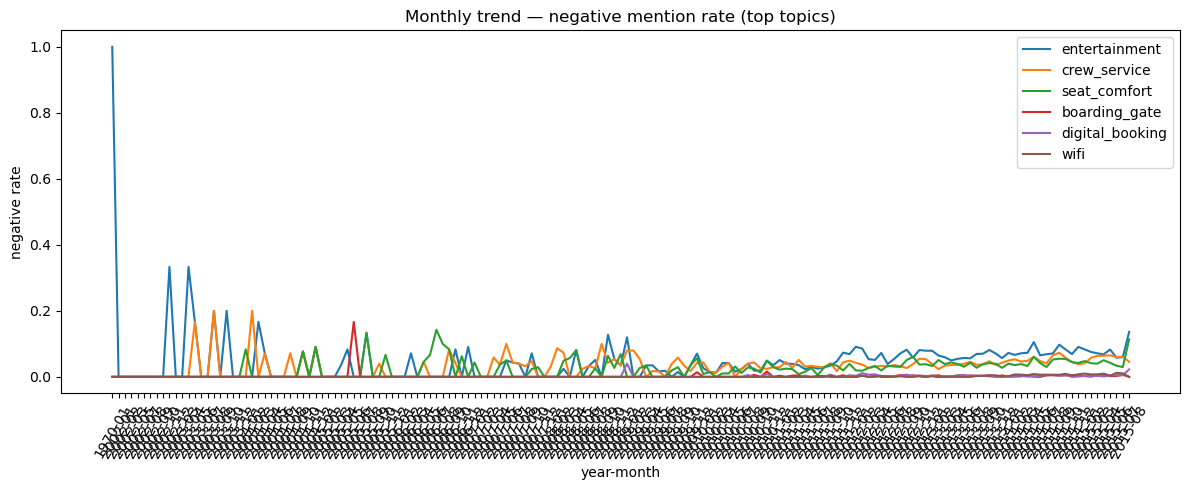

In [11]:
# Plot: Top 6 topics by avg negative rate
avg_rates = {t: trend[f'{t}_neg_rate'].mean() for t in TOPIC_KEYWORDS.keys()}
top6 = sorted(avg_rates, key=avg_rates.get, reverse=True)[:6]

plt.figure(figsize=(12,5))
for t in top6:
    plt.plot(trend['year_month'], trend[f'{t}_neg_rate'], label=t)

plt.title('Monthly trend — negative mention rate (top topics)')
plt.xticks(rotation=60)
plt.ylabel('negative rate')
plt.xlabel('year-month')
plt.legend()
plt.tight_layout()
plt.show()


## 5.2 Trend chart — negative mention rate for top topics

This plot shows the **monthly negative mention rate** for the **top 6 topics**, where:

$$
\text{negative mention rate}_{t,m} = \frac{\#(\text{reviews in month } m \text{ that mention topic } t \ \&\ \text{predicted negative})}{\#(\text{all reviews in month } m)}
$$

### How to read the chart
- Each line corresponds to a topic (e.g., `seat_comfort`, `crew_service`, `entertainment`).
- The y-axis is a **rate** (0–1). A value of **0.08** means ~8% of all reviews in that month were both:
  1) tagged with that topic and  
  2) predicted negative by the sentiment model.

This metric is a “volume-of-negative-feedback” proxy: it increases when a topic is mentioned more often in negative reviews and/or when overall review volume stays stable.

### Interpretation notes (why the early plot looks noisy)
Several common issues can make the early part of the chart look “spiky” and the x-axis overcrowded:

1. **Low review volume months**
   - If `total_reviews` is very small (e.g., 1–5 reviews), the rate becomes unstable:
     - With 1 review, the rate is either 0 or 1.
   - This creates tall spikes that are not representative of a true trend.

2. **Long historical range**
   - Plotting every month across many years produces overlapping x-tick labels, making the time axis hard to read.

3. **Mean-based topic selection can be biased**
   - Selecting “top topics” by the simple mean of `*_neg_rate` across all months can overweight periods with low review volume.
   - A more stable approach uses either:
     - a minimum-volume filter (e.g., months with ≥50 reviews), and/or
     - a **weighted average** by `total_reviews`.

### Recommended adjustments (for recruiter-friendly readability)
To make trend visuals more interpretable and portfolio-ready, the following are typically applied:
- Filter to months with sufficient volume (e.g., `total_reviews >= 30` or `>= 50`)
- Focus on the **last 24–36 months** (or a clearly defined recent window)
- Plot a **rolling mean** (e.g., 3-month moving average) to reduce noise
- Convert `year_month` to a datetime type and use date tick locators for clean labels

The next cell applies these changes to produce a cleaner trend chart.


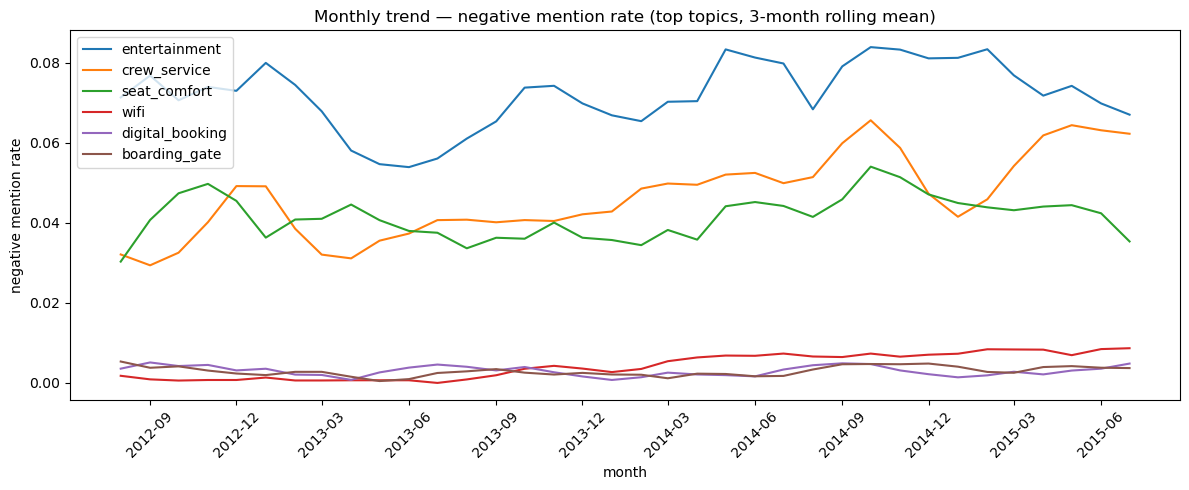

In [17]:
import matplotlib.dates as mdates

# --- Cleaner, portfolio-ready trend plot ---

trend2 = trend.copy()

# 1) Parse year_month for proper date handling
trend2['year_month_dt'] = pd.to_datetime(trend2['year_month'].astype(str) + '-01', errors='coerce')
trend2 = trend2.dropna(subset=['year_month_dt']).sort_values('year_month_dt')

# 2) Filter out very low-volume months (reduces spiky rates)
MIN_REVIEWS = 50
trend2 = trend2[trend2['total_reviews'] >= MIN_REVIEWS].copy()

# 3) Pick a recent window (optional but recommended for readability)
LAST_N_MONTHS = 36
if len(trend2) > LAST_N_MONTHS:
    trend2 = trend2.iloc[-LAST_N_MONTHS:]

# 4) Pick top topics using a weighted mean (more robust than simple mean)
weighted_avg = {}
for t in TOPIC_KEYWORDS.keys():
    weighted_avg[t] = np.average(trend2[f'{t}_neg_rate'], weights=trend2['total_reviews'])
top6 = sorted(weighted_avg, key=weighted_avg.get, reverse=True)[:6]

# 5) Optional smoothing (rolling mean)
ROLLING = 3
for t in top6:
    trend2[f'{t}_neg_rate_sm'] = trend2[f'{t}_neg_rate'].rolling(ROLLING, min_periods=1).mean()

plt.figure(figsize=(12,5))
for t in top6:
    plt.plot(trend2['year_month_dt'], trend2[f'{t}_neg_rate_sm'], label=t)

plt.title(f'Monthly trend — negative mention rate (top topics, {ROLLING}-month rolling mean)')
plt.ylabel('negative mention rate')
plt.xlabel('month')

# Clean date ticks
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


## 5.3 Interpreting the monthly trend (top topics, 3-month rolling mean)

This chart summarizes the **negative mention rate** over time for the most prominent topics, using a **3-month rolling mean** to reduce month-to-month noise.

### What the metric represents
For each topic and month, the **negative mention rate** is:

$$
\frac{\#(\text{reviews that mention the topic and are predicted negative})}{\#(\text{all reviews in that month})}
$$

A value of **0.06** means ~6% of all reviews in that month contain negative feedback about that topic.

### Key observations from the plot
- **Entertainment** is consistently the highest line across the period, indicating it is the most persistent source of negative mentions among the top topics. It fluctuates but remains elevated, suggesting a recurring experience gap rather than isolated incidents.

- **Crew service** shows a clear upward trend over the window, with noticeable peaks later in the period. This pattern can indicate either a genuine service consistency issue emerging over time or a shift in customer expectations/visibility.

- **Seat comfort** remains high and volatile relative to most topics, with repeated peaks. This is typical of comfort-related feedback: small operational or product changes (aircraft swaps, seat configurations, load factors) can shift perception quickly.

- **Wi-Fi** increases gradually from near-zero to a higher (but still lower than the top three) negative mention rate. The gradual rise often aligns with greater customer reliance on connectivity and higher expectations, even if availability improves.

- **Digital booking** and **boarding/gate** remain low and relatively stable in this window. Low rate does not necessarily mean “solved”; it can also mean the issue is less frequently mentioned in reviews or is handled through other support channels.

### How this feeds prioritization
A practical prioritization lens combines:
- **Frequency**: negative mention rate (volume of negative feedback)
- **Severity**: average `p_neg` within topic mentions (intensity of negativity)

Topics that are **high-frequency and high-severity** tend to be the best candidates for cross-functional initiatives and measurable backlog items.


## 7) Severity vs. frequency (prioritization)
A simple prioritization matrix:
- **Frequency:** share of negative reviews that mention the aspect
- **Severity:** mean `p_neg` among negative reviews for that aspect
- **Priority score:** `frequency * severity`

This view supports cross-functional alignment on what to address first.



In [12]:
# fokus ke periode terbaru (mis. 12 bulan terakhir) — tweak sesuai kebutuhan
last_n_months = 12
recent_months = trend['year_month'].unique()[-last_n_months:]
df_recent = df[df['year_month'].isin(recent_months)].copy()

prior_rows=[]
neg_total = (df_recent['is_negative'] == 1).sum()

for t in TOPIC_KEYWORDS.keys():
    topic_mask = df_recent[t] == 1
    neg_topic = df_recent[(df_recent['is_negative']==1) & topic_mask]
    freq = len(neg_topic) / neg_total if neg_total else 0
    sev = float(neg_topic['p_neg'].mean()) if len(neg_topic) and 'p_neg' in df_recent.columns else np.nan
    prior_rows.append({
        'topic': t,
        'neg_mentions': len(neg_topic),
        'frequency_share_of_negative': freq,
        'severity_avg_p_neg': sev,
        'priority_score': freq * (sev if not np.isnan(sev) else 0)
    })

prio = pd.DataFrame(prior_rows).sort_values('priority_score', ascending=False)
display(prio)


,topic,neg_mentions,frequency_share_of_negative,severity_avg_p_neg,priority_score
9,entertainment,894,0.167165,0.763391,0.127613
1,crew_service,671,0.125467,0.791885,0.099356
0,seat_comfort,514,0.096111,0.755943,0.072654
3,wifi,97,0.018138,0.758980,0.013766
4,boarding_gate,47,0.008788,0.703577,0.006183
8,digital_booking,41,0.007666,0.747319,0.005729
5,delay_punctuality,0,0.000000,NaN,0.000000
2,food_bev,0,0.000000,NaN,0.000000
7,cleanliness,0,0.000000,NaN,0.000000
6,baggage,0,0.000000,NaN,0.000000


## 6.1 Prioritization in the most recent period (last 12 months)

Trend lines help describe *what is changing over time*. For action planning, a concise way to translate VoC signals into a backlog is to compute a **priority score** over a recent window (e.g., the last 12 months).

This section focuses on the most recent `last_n_months` and ranks topics using a simple **frequency × severity** framework.

---

### Step 1 — Define the analysis window (recency)
The code selects the most recent 12 `year_month` values from the monthly trend table and filters reviews to that period:

- This keeps the prioritization aligned with the current customer experience.
- The window size can be adjusted (e.g., 6, 12, 24 months) depending on seasonality and review volume.

---

### Step 2 — Define frequency and severity (within negative feedback)

**A) Frequency (share of negative mentions)**  
For each topic `t`:

$$
\text{frequency\_share}_t
= \frac{\#(\text{negative reviews that mention } t)}{\#(\text{all negative reviews})}
$$

Interpretation:
- A higher value means the topic represents a larger share of overall negative feedback in the recent period.
- This normalizes by the total number of negative reviews, making comparisons more stable than raw counts.

**B) Severity (average negative probability)**  
Severity is the mean `p_neg` among negative reviews mentioning the topic:

$$
\text{severity}_t = \text{mean}\left(p_{neg} \mid \text{negative review and topic } t \text{ mentioned}\right)
$$

Interpretation:
- Higher severity means the topic is associated with more strongly negative language.
- Probability-based severity is useful because it remains meaningful even when class boundaries are imperfect.

**C) Priority score**
A simple composite score is used:

$$
\text{priority\_score}_t = \text{frequency\_share}_t \times \text{severity}_t
$$

This emphasizes topics that are both:
- **common within negative feedback**, and
- **intense when they occur**

---

### Results interpretation (recent 12 months)

Ranked by `priority_score`:

1. **entertainment**  
   - neg_mentions: 894  
   - frequency_share_of_negative: 0.167  
   - severity_avg_p_neg: 0.763  
   - priority_score: 0.128  
   **Interpretation:** The largest contributor to negative feedback in the recent window and still strongly negative when mentioned. This is a high-confidence backlog candidate.

2. **crew_service**  
   - neg_mentions: 671  
   - frequency_share_of_negative: 0.125  
   - severity_avg_p_neg: 0.792  
   - priority_score: 0.099  
   **Interpretation:** High severity and high share of negative feedback. This suggests service consistency and interaction quality are major drivers of dissatisfaction.

3. **seat_comfort**  
   - neg_mentions: 514  
   - frequency_share_of_negative: 0.096  
   - severity_avg_p_neg: 0.756  
   - priority_score: 0.073  
   **Interpretation:** Frequent and meaningfully negative; typically points to comfort expectations (legroom, seat condition) and potential segmentation by aircraft/cabin.

4. **wifi**  
   - neg_mentions: 97  
   - frequency_share_of_negative: 0.018  
   - severity_avg_p_neg: 0.759  
   - priority_score: 0.014  
   **Interpretation:** Lower volume but still high severity. Often an “expectation gap” issue: customers mention it when it fails.

5. **boarding_gate**  
   - neg_mentions: 47  
   - frequency_share_of_negative: 0.009  
   - severity_avg_p_neg: 0.704  
   - priority_score: 0.006  
   **Interpretation:** Smaller contributor in this window; may still be important for specific airports/routes.

6. **digital_booking**  
   - neg_mentions: 41  
   - frequency_share_of_negative: 0.008  
   - severity_avg_p_neg: 0.747  
   - priority_score: 0.006  
   **Interpretation:** Low overall share; potential to investigate via customer support logs where digital pain points are often reported more than in reviews.

---

### Why some topics show zeros
Topics such as `delay_punctuality`, `food_bev`, `baggage`, and `cleanliness` show zero negative mentions in this recent window. Common explanations include:

- The review sample for this period may be concentrated around certain experience dimensions.
- The keyword taxonomy may miss synonyms or phrasing used in recent reviews.
- The chosen metric counts **negative reviews that mention the topic**; if the model under-predicts negative for those themes, counts can drop.
- The recent window may have relatively few reviews mentioning these topics.

A quick validation is recommended:
- Inspect a sample of negative reviews (`p_neg` high) that are **untagged** by these topics.
- Expand keywords with observed synonyms (e.g., “lost my suitcase” for baggage, “cancelled” variants for delays).

---

### How to use this table in backlog planning
The top three topics (`entertainment`, `crew_service`, `seat_comfort`) form the core backlog candidates because they dominate both frequency and severity in the most recent period. Lower-ranked topics can be treated as:
- targeted improvements for specific segments (route/aircraft),
- or “watchlist” items tracked monthly for early warning signals.

The next step translates the top-ranked topics into a concrete improvement backlog with:
- a clear problem statement,
- a proposed intervention,
- success KPIs, and
- tracking instrumentation.


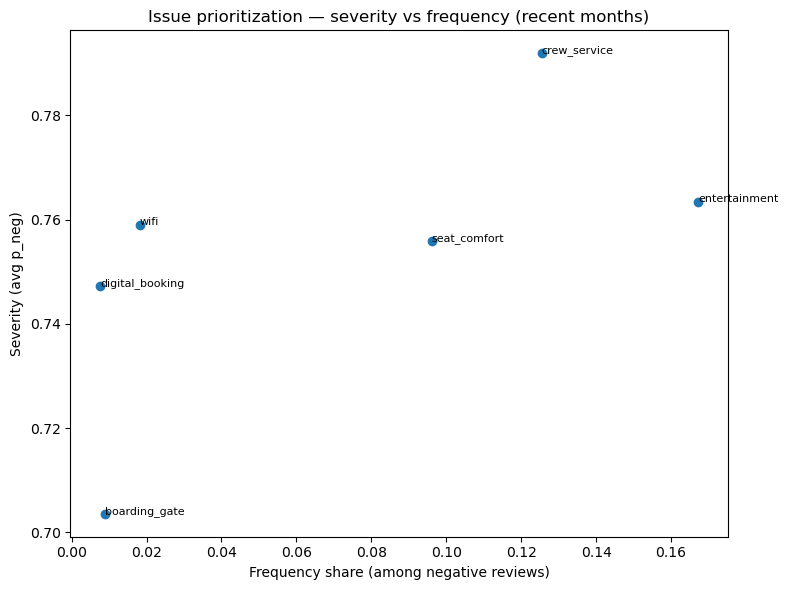

In [13]:
# Scatter plot: severity vs frequency
plt.figure(figsize=(8,6))
plt.scatter(prio['frequency_share_of_negative'], prio['severity_avg_p_neg'])

for _, r in prio.iterrows():
    plt.annotate(r['topic'], (r['frequency_share_of_negative'], r['severity_avg_p_neg']), fontsize=8)

plt.title('Issue prioritization — severity vs frequency (recent months)')
plt.xlabel('Frequency share (among negative reviews)')
plt.ylabel('Severity (avg p_neg)')
plt.tight_layout()
plt.show()


## 6.2 Priority matrix: severity vs frequency (recent months)

This scatter plot summarizes issue prioritization using two complementary dimensions, computed over the most recent analysis window (e.g., last 12 months):

- **Frequency (x-axis):** share of negative reviews that mention the topic  
  $$
  \text{frequency\_share}_t=\frac{\#(\text{negative reviews mentioning }t)}{\#(\text{all negative reviews})}
  $$
- **Severity (y-axis):** average predicted negative probability (`p_neg`) among negative reviews mentioning the topic  
  $$
  \text{severity}_t = \text{mean}\left(p_{neg} \mid \text{negative review and mentions } t\right)
  $$

### How to interpret the quadrants
- **Top-right (high frequency, high severity):** highest priority. These topics drive a large portion of negative feedback and are expressed with strong negative language.
- **Top-left (low frequency, high severity):** “sharp pain points.” Less common, but highly negative when they occur; often good candidates for targeted fixes.
- **Bottom-right (high frequency, lower severity):** frequent friction. Improvements can still deliver impact through scale, even if the language is less extreme.
- **Bottom-left (low frequency, low severity):** lowest priority for the current window; typically tracked on a watchlist.

### Key takeaways from the current plot
- **Entertainment** appears as the most frequent driver of negative feedback (furthest right). Severity is also high, placing it among the strongest backlog candidates by impact.
- **Crew service** combines **high severity** with meaningful frequency, placing it in the top priority region. This is typically associated with consistency and service delivery across crews and routes.
- **Seat comfort** sits in a high-impact position with both moderate-to-high frequency and high severity, indicating a persistent experience gap linked to comfort expectations.
- **Wi-Fi** and **digital booking** show relatively lower frequency but high severity, consistent with “failure-mode” topics: they are mentioned less often, but when mentioned, dissatisfaction is strong.
- **Boarding/gate** is lower in both frequency and severity in this window, suggesting a smaller overall contribution to negative feedback at the aggregate level. This topic may still matter in specific airports or operational conditions.

### Recommended use in backlog translation
This matrix supports a practical decision rule:
- Prioritize **top-right topics** for cross-functional initiatives with clear KPIs and owners.
- Treat **top-left topics** as targeted reliability fixes (often technology/process-specific).
- Keep **bottom-left topics** as a monitored set for early warning signals, especially if trends shift over time.

The next step converts the top topics into a structured improvement backlog with measurable success metrics and tracking plans.


## 8) Translating insights into a product backlog (10 initiatives)
In product/operations work, insights become:
- a clear **problem statement**
- a **solution hypothesis**
- **success metrics (KPIs)** and a tracking plan

This notebook generates a draft backlog from top issues. Wording can be adjusted to match the target airline context.



In [14]:
# Helper: pilih top topics
TOP_K = 5
focus_topics = prio.head(TOP_K)['topic'].tolist()
focus_topics


['entertainment', 'crew_service', 'seat_comfort', 'wifi', 'boarding_gate']

## 6.3 Select focus topics for backlog translation

To keep the backlog actionable, the next step limits deep-dive analysis to the highest-priority themes from the recent-window ranking.

### Selection rule
- Topics are ranked by `priority_score` (frequency × severity).
- The analysis then selects the **top K topics** for detailed backlog translation.

In this run:
- `TOP_K = 5`

### Focus topics (top 5)
The selected focus topics are:

1. `entertainment`
2. `crew_service`
3. `seat_comfort`
4. `wifi`
5. `boarding_gate`

### Why limiting the number of topics is useful
Focusing on a small set of themes helps:
- Maintain a clear narrative and avoid “laundry list” outputs
- Align cross-functional owners around a manageable set of initiatives
- Define measurable KPIs and instrumentation per initiative

The next section translates each focus topic into concrete improvement ideas, including success metrics and tracking mechanisms.


## 7.1 Translate prioritized VoC themes into a product/ops backlog

The prioritization table identifies which topics are most impactful in the recent period. The next step is to convert those signals into a **backlog of initiatives** that can be executed by cross-functional teams (Product, Cabin, Ground Ops, Engineering, Customer Care).

Each backlog item includes:
- **Initiative:** a clear, action-oriented improvement statement
- **Primary topic:** the VoC theme it addresses
- **Why:** the customer problem framed in business terms
- **Success KPIs:** measurable outcomes to define “done”
- **How to track:** instrumentation and data sources to monitor progress

This structure supports communication with stakeholders by connecting:
**customer language → measurable impact → operational/product actions.**


In [18]:
# Backlog ideas (editable)
backlog = [
    {
        'initiative': 'Stabilize onboard Wi-Fi reliability and speed',
        'primary_topic': 'wifi',
        'why': 'Connectivity failures are repeatedly associated with negative sentiment and reduce perceived value, especially on longer flights.',
        'kpi_success': 'Decrease negative Wi-Fi mentions per 1k reviews; increase Wi-Fi CSAT; increase satisfaction on Wi-Fi equipped routes',
        'how_to_track': 'Weekly topic dashboard (wifi); onboard Wi-Fi telemetry (uptime, throughput, session success); post-flight micro-survey item'
    },
    {
        'initiative': 'Improve boarding flow and gate communications',
        'primary_topic': 'boarding_gate',
        'why': 'Queue management and unclear gate instructions create avoidable friction and can amplify disruption stress.',
        'kpi_success': 'Decrease boarding/gate negative mentions; reduce boarding time variability; improve on-time departure readiness indicators',
        'how_to_track': 'Gate timestamps; boarding scan data; trend breakdown by station/airport; targeted audit sampling'
    },
    {
        'initiative': 'Reduce seat comfort pain points (legroom expectations, cushioning, recline issues)',
        'primary_topic': 'seat_comfort',
        'why': 'Seat comfort strongly influences overall trip satisfaction on medium/long flights and is frequently cited in negative feedback.',
        'kpi_success': 'Increase seat comfort score; decrease seat-related negative mentions; increase recommendation rate on affected aircraft types',
        'how_to_track': 'Map reviews to fleet/cabin; before/after comparison by tail number where feasible; maintenance findings; post-flight survey'
    },
    {
        'initiative': 'Service consistency program for cabin crew',
        'primary_topic': 'crew_service',
        'why': 'Service attitude and responsiveness appear frequently and carry high emotional intensity in reviews.',
        'kpi_success': 'Decrease negative crew mentions; increase cabin staff rating; increase compliments-to-complaints ratio',
        'how_to_track': 'VoC topic + sentiment trend by crew base and route; onboard survey; quality assurance sampling and coaching follow-up'
    },
    {
        'initiative': 'Increase in-flight entertainment reliability and content freshness',
        'primary_topic': 'entertainment',
        'why': 'IFE reliability issues reduce perceived value and are a consistent driver of dissatisfaction on longer flights.',
        'kpi_success': 'Decrease IFE negative mentions; increase IFE rating; increase IFE usage rate',
        'how_to_track': 'IFE system health logs; content update cadence metrics; VoC trend by fleet type'
    },

    # Optional additional initiatives (kept for completeness / future scope)
    {
        'initiative': 'Disruption experience: proactive communication and re-accommodation',
        'primary_topic': 'delay_punctuality',
        'why': 'Disruptions drive strong dissatisfaction, particularly when updates and rebooking are unclear or slow.',
        'kpi_success': 'Decrease disruption-related negative rate; increase satisfaction among disrupted passengers; reduce missed-connection complaints',
        'how_to_track': 'Link VoC topics with OTP/irregular operations logs; measure notification timeliness; track rebooking time-to-confirm'
    },
    {
        'initiative': 'Refresh meals on key routes and improve special-meal reliability',
        'primary_topic': 'food_bev',
        'why': 'Meal quality and availability shape brand perception and are frequently mentioned when expectations are not met.',
        'kpi_success': 'Decrease food negative mentions; increase food rating; reduce catering incident rate',
        'how_to_track': 'Catering QA checks; incident logs; VoC trend by route and cabin'
    },
    {
        'initiative': 'Baggage handling: reduce lost/damaged bags and speed up delivery',
        'primary_topic': 'baggage',
        'why': 'Baggage issues are high-stress and high-cost events that disproportionately affect overall satisfaction.',
        'kpi_success': 'Decrease mishandled bag rate; decrease baggage negative mentions; reduce claim cycle time',
        'how_to_track': 'Baggage tracking data (e.g., tracing systems); station SLA metrics; VoC trend by arrival airport'
    },
    {
        'initiative': 'Cabin cleanliness and lavatory turnaround standards',
        'primary_topic': 'cleanliness',
        'why': 'Cleanliness signals quality and safety; negative mentions can quickly erode trust.',
        'kpi_success': 'Decrease cleanliness negative mentions; increase cleanliness rating; increase audit pass rate',
        'how_to_track': 'Turnaround checklist data; contractor SLA compliance; random audits; VoC trend by fleet type'
    },
    {
        'initiative': 'Digital experience: booking and refund transparency with self-serve workflows',
        'primary_topic': 'digital_booking',
        'why': 'Booking and refund friction is associated with dissatisfaction and downstream contact-center demand.',
        'kpi_success': 'Decrease booking/refund negative mentions; reduce contact-center volume; reduce time-to-refund',
        'how_to_track': 'Support ticket tags; web/app funnel analytics; SLA dashboards; VoC mining for refund-related phrases'
    },
]

backlog_df = pd.DataFrame(backlog)

# Optional: keep only focus topics for the "top-K" narrative
TOP_K = 5
focus_topics = prio.head(TOP_K)['topic'].tolist()
backlog_focus = backlog_df[backlog_df['primary_topic'].isin(focus_topics)].reset_index(drop=True)

display(backlog_focus)


,initiative,primary_topic,why,kpi_success,how_to_track
0,Stabilize onboard Wi-Fi reliability and speed,wifi,"Connectivity failures are repeatedly associated with negative sentiment and reduce perceived value, especially on lo...",Decrease negative Wi-Fi mentions per 1k reviews; increase Wi-Fi CSAT; increase satisfaction on Wi-Fi equipped routes,"Weekly topic dashboard (wifi); onboard Wi-Fi telemetry (uptime, throughput, session success); post-flight micro-surv..."
1,Improve boarding flow and gate communications,boarding_gate,Queue management and unclear gate instructions create avoidable friction and can amplify disruption stress.,Decrease boarding/gate negative mentions; reduce boarding time variability; improve on-time departure readiness indi...,Gate timestamps; boarding scan data; trend breakdown by station/airport; targeted audit sampling
2,"Reduce seat comfort pain points (legroom expectations, cushioning, recline issues)",seat_comfort,Seat comfort strongly influences overall trip satisfaction on medium/long flights and is frequently cited in negativ...,Increase seat comfort score; decrease seat-related negative mentions; increase recommendation rate on affected aircr...,Map reviews to fleet/cabin; before/after comparison by tail number where feasible; maintenance findings; post-flight...
3,Service consistency program for cabin crew,crew_service,Service attitude and responsiveness appear frequently and carry high emotional intensity in reviews.,Decrease negative crew mentions; increase cabin staff rating; increase compliments-to-complaints ratio,VoC topic + sentiment trend by crew base and route; onboard survey; quality assurance sampling and coaching follow-up
4,Increase in-flight entertainment reliability and content freshness,entertainment,IFE reliability issues reduce perceived value and are a consistent driver of dissatisfaction on longer flights.,Decrease IFE negative mentions; increase IFE rating; increase IFE usage rate,IFE system health logs; content update cadence metrics; VoC trend by fleet type


## 7.2 Focus backlog (top 5 topics) — interpretation and how to use it

The table below translates the five highest-priority VoC topics into a concrete, execution-ready backlog. Each item includes the customer problem (“why”), a measurable definition of success (KPIs), and a tracking plan that ties VoC signals to operational or product telemetry.

### Portfolio narrative (what this demonstrates)
- **Customer insight translation:** unstructured reviews are converted into prioritized themes and then into initiatives with measurable outcomes.
- **Cross-functional framing:** each initiative is mapped to data sources owned by different teams (Ops, Digital, Cabin, Engineering).
- **Measurement discipline:** success criteria are defined upfront and tracked through both VoC and operational instrumentation.

### Recommended prioritization order (based on frequency × severity)
1. **In-flight entertainment reliability & content freshness (`entertainment`)**  
   High share of negative feedback and consistently high negativity when mentioned. This is typically a “value perception” driver on longer flights and can be tracked through both system logs and VoC trends.

2. **Cabin crew service consistency (`crew_service`)**  
   High severity with meaningful frequency. Often requires process and training interventions, supported by QA audits and route/base segmentation.

3. **Seat comfort pain points (`seat_comfort`)**  
   Persistent driver of dissatisfaction. Best handled with segmentation (fleet type, cabin, seat configuration) and a before/after evaluation where changes are deployed.

4. **Onboard Wi-Fi reliability (`wifi`)**  
   Lower frequency but high severity. This pattern is consistent with a “failure-mode” experience: it may be mentioned mainly when it fails. Telemetry is essential to distinguish coverage gaps vs performance issues.

5. **Boarding and gate communications (`boarding_gate`)**  
   Lower aggregate contribution in this window but often concentrated by station/airport. This is a good candidate for targeted pilots at a small number of high-impact locations.

### How to operationalize the backlog
A practical execution plan is:
- Assign **one owner per initiative** and define the primary measurement cadence (weekly VoC, daily ops telemetry, monthly KPI review).
- Add **segmentation fields** where possible (route, aircraft type, cabin, station) to identify hotspots and prevent “averages” from masking localized problems.
- Track impact using a dual lens:
  - **VoC metrics** (negative mention rate, topic severity)
  - **Operational/product metrics** (telemetry, timestamps, QA/audits)

### Suggested “definition of done” (common to all initiatives)
- Sustained reduction in **topic-specific negative mention rate** over multiple months
- Improvement in **topic-specific CSAT** (or relevant operational KPI) without regression in adjacent metrics
- Clear ownership and monitoring in a lightweight dashboard

The next step typically adds:
- **Two concrete experiments per initiative** (pilot design) and
- A simple **dashboard spec** (what charts/tables to monitor weekly).


In [19]:
# Export backlog to CSV for portfolio / sharing
out_csv = Path('case_study_3_backlog_ideas.csv')
backlog_df.to_csv(out_csv, index=False)
print('saved:', out_csv.resolve())


saved: /Users/user/Desktop/Case Study 3 —/case_study_3_backlog_ideas.csv


## 9) Executive Summary

This case study builds an end-to-end **Voice of Customer (VoC) analytics pipeline** that converts unstructured airline reviews into **decision-ready insights** for product and operations teams.

- **What was built**  
  A complete workflow that processes **40k+ airline reviews**, produces **monthly issue trends** (frequency and severity), and translates findings into a **prioritized improvement backlog** with measurable success criteria.

- **Method**  
  - **Sentiment:** weakly supervised text classifier using **TF-IDF + Logistic Regression**, trained from rating-derived proxy labels (pos/neu/neg).  
  - **Topics / aspects:** an interpretable, business-friendly **keyword taxonomy** (e.g., seat comfort, crew service, Wi-Fi, boarding/gate).  
  - **Discovery (optional):** **NMF topic modeling** on a review sample to surface additional recurring themes and validate coverage of the taxonomy.

- **Outputs**  
  - Topic-level **trend reporting** by month (negative mention rate + severity via `p_neg`)  
  - A **severity vs frequency priority matrix** for recent months  
  - A backlog of improvement initiatives with:
    - **Problem framing** (“why this matters”)
    - **Success KPIs** (clear definition of impact)
    - **Tracking plan** (VoC + telemetry/ops data sources)

- **Impact framing**  
  The pipeline enables cross-functional execution by connecting customer language to measurable outcomes, supporting prioritization, and providing a repeatable monitoring mechanism for ongoing service quality management.

### Next-step extensions
- **Entity extraction and segmentation:** route, airport/station, aircraft type, cabin class, and service tier to identify operational hotspots.  
- **Drill-down views:** airline-level or fleet-level dashboards to compare performance across segments.  
- **Automated alerting:** spike detection on negative mention rate and severity with thresholds and weekly notifications for emerging issues.


## Appendix — Dataset link (reference)
Repository: `quankiquanki/skytrax-reviews-dataset`
File: `data/airline.csv`

Optional: load directly from the raw CSV URL:
```python
import pandas as pd
url = 'https://raw.githubusercontent.com/quankiquanki/skytrax-reviews-dataset/master/data/airline.csv'
df = pd.read_csv(url)
```

